<a href="https://colab.research.google.com/github/aruaru0/Foursquare-Location-Matching/blob/main/Foursquare%E3%81%AE%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A9%E3%82%A4%E3%83%B3%E3%82%92%E7%90%86%E8%A7%A3%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab用用kaggle関連設定

In [1]:
import sys

In [4]:
is_colab = False
if "google.colab" in sys.modules:
  is_colab = True

In [5]:
if is_colab:
  !mkdir -p ~/.kaggle
  !cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/
  !pip install kaggle
  !apt install unzip
  !chmod 600 /root/.kaggle/kaggle.json

  !kaggle competitions download -c foursquare-location-matching
  !mkdir input output
  !unzip foursquare-location-matching.zip -d input/foursquare-location-matching

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
 96% 153M/159M [00:01<00:00, 112MB/s]
100% 159M/159M [00:01<00:00, 118MB/s]
Archive:  foursquare-location-matching.zip
  inflating: input/foursquare-location-matching/pairs.csv  
  inflating: input/foursquare-location-matching/sample_submission.csv  
  inflating: input/foursquare-location-matching/test.csv  
  inflating: input/foursquare-location-matching/train.csv  


In [117]:
if is_colab :
    !pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 52.6 MB/s 
     |████████████████████████████████| 103 kB 54.7 MB/s 


In [6]:
if is_colab :
  %cd /content/output

/content/output


# start here.

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

import Levenshtein
import difflib

import lightgbm as lgbm

In [49]:
class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 5
    n_splits = 3

In [14]:
random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

### ファイルの読み込み

In [12]:
train = pd.read_csv("../input/foursquare-location-matching/train.csv")
test = pd.read_csv("../input/foursquare-location-matching/test.csv")
test[CFG.target] = "TEST"

train.head(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


### Trainを分割する

In [18]:
kf = GroupKFold(n_splits=2)
for i,(trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])) : 
  train.loc[val_idx, "set"] = i
train['set'].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

### 候補を検索

In [58]:
def add_neighbor_features(df) :
  dfs = []
  columns = ['id', 'name', 'address', 'city', 'state',
          'zip', 'country', 'url', 'phone', 'categories']

  # 小文字に変換
  for c in columns:
    if c != "id":
        df[c] = df[c].astype(str).str.lower()

  # 国ごとに分割して処理
  for country, country_df in tqdm(df.groupby("country")):
      country_df = country_df.reset_index(drop=True) # 削除したindexを列に加えずに新たに番号をつける
      
      # k-最近傍法
      knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                metric='haversine', n_jobs=-1)
      knn.fit(country_df[['latitude','longitude']], country_df.index)
      # dists: 距離 nears: インデックス
      dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)

      # 近傍に対して距離d_near_xと,　インデックスnear_target_x, 近傍の情報をセット
      targets = country_df[CFG.target].values
      for i in range(min(len(country_df), CFG.n_neighbors)):
          country_df[f"d_near_{i}"] = dists[:, i]
          country_df[f"near_target_{i}"] = targets[nears[:, i]]
          for c in columns:
              country_df[f"near_{c}_{i}"] = country_df[c].values[nears[:, i]]

      # 近傍からもれた（TOPxxに入らなかった）データに関してはnanを入れる
      for i in range(min(len(country_df), CFG.n_neighbors), CFG.n_neighbors):
          country_df[f"d_near_{i}"] = np.nan
          country_df[f"near_target_{i}"] = np.nan
          for c in columns:
              country_df[f"near_{c}_{i}"] = np.nan

      dfs.append(country_df)
  df = pd.concat(dfs).reset_index(drop=True)
  return df

In [59]:
train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:01<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id_4,near_name_4,near_address_4,near_city_4,near_state_4,near_zip_4,near_country_4,near_url_4,near_phone_4,near_categories_4
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_4a34a5012e88c3,pic negre 11,nan,la massana,nan,ad400,ad,nan,737350,sporting goods shops


In [60]:
train.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories', 'point_of_interest',
       'set', 'd_near_0', 'near_target_0', 'near_id_0', 'near_name_0',
       'near_address_0', 'near_city_0', 'near_state_0', 'near_zip_0',
       'near_country_0', 'near_url_0', 'near_phone_0', 'near_categories_0',
       'd_near_1', 'near_target_1', 'near_id_1', 'near_name_1',
       'near_address_1', 'near_city_1', 'near_state_1', 'near_zip_1',
       'near_country_1', 'near_url_1', 'near_phone_1', 'near_categories_1',
       'd_near_2', 'near_target_2', 'near_id_2', 'near_name_2',
       'near_address_2', 'near_city_2', 'near_state_2', 'near_zip_2',
       'near_country_2', 'near_url_2', 'near_phone_2', 'near_categories_2',
       'd_near_3', 'near_target_3', 'near_id_3', 'near_name_3',
       'near_address_3', 'near_city_3', 'near_state_3', 'near_zip_3',
       'near_country_3', 'near_url_3', 'near_phone_3', 'near_categories_3',
   

### ターゲット作成

In [73]:
# ターゲットと同じID番号の近傍のインデックスをtargetに設定する
for i in range(CFG.n_neighbors) :
  train.loc[train[CFG.target]==train[f"near_target_{i}"], "target"] = i

In [74]:
train[[CFG.target,"near_target_0","near_target_1", "target"]].head()

,point_of_interest,near_target_0,near_target_1,target
0,P_a12b9416902417,P_a12b9416902417,P_a12b9416902417,1.0
1,P_9299650d4117cd,P_9299650d4117cd,P_9299650d4117cd,1.0
2,P_ab8804cceda471,P_ab8804cceda471,P_031de1c60f837c,0.0
3,P_8a1a127b787fbe,P_8a1a127b787fbe,P_8a1a127b787fbe,1.0
4,P_15f4dafd9cc0f4,P_15f4dafd9cc0f4,P_d872fef9bf109f,0.0


In [76]:
sorted(train['target'].unique())

[0.0, 1.0, 2.0, 3.0, 4.0, nan]

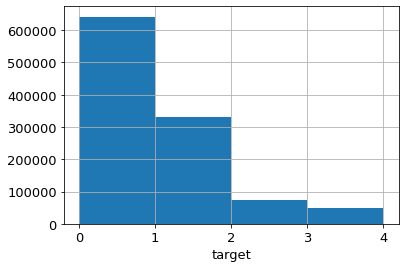

In [77]:
# ターゲットの分布頻度をグラフ表示
plt.hist(train["target"], bins=sorted(train["target"].unique()))
plt.grid()
plt.xlabel("target")
plt.show()

### 最大スコアをチェック

In [92]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
  return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
  return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

# KNNで選ばれたデータの正解のカバー率を計測する
def get_score(input_df: pd.DataFrame):
  scores = []
  for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
    targets = poi2ids[id2poi[id_str]]
    preds = set(matches.split())
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
  scores = np.array(scores)
  return scores.mean()

In [93]:
# id --> poi変換用の辞書. １対１の関係
id2poi = get_id2poi(train)
# poi --> id変換用の辞書辞書. １対多の関係
poi2ids = get_poi2ids(train)

In [100]:
# match列に一致するIDを列挙する
scores = []

train["matches"] = ""
for i in tqdm(range(CFG.n_neighbors)):
  # point_of_interestが一致しているかどうか調べ、一致しているもののIDをmatchに追加していく
  idx = train[CFG.target]==train[f"near_target_{i}"]
  train.loc[idx, "matches"] += " " + train.loc[idx, f"near_id_{i}"]
  scores.append(get_score(train))


  0%|          | 0/5 [00:00<?, ?it/s]

In [111]:
train[["id", "matches"]].head()

,id,matches
0,E_1104d3664585a4,E_1104d3664585a4 E_be8ec27bf1b71b
1,E_1514d74b987ae1,E_1514d74b987ae1 E_dfa69a18228406
2,E_206f06060f193d,E_206f06060f193d
3,E_20b7920b07557d,E_20b7920b07557d E_9acdcda349c154
4,E_4a34a5012e88c3,E_4a34a5012e88c3


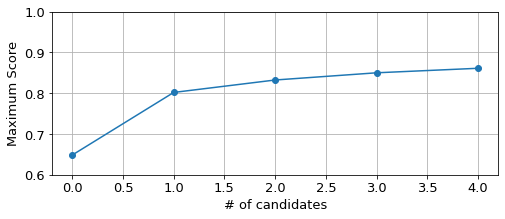

In [112]:
# n近傍に対する正解が含まれる割合をグラフ化
plt.subplots(figsize=(8, 3), facecolor="white")
plt.plot(range(CFG.n_neighbors), scores, marker="o")
plt.grid()
plt.xlabel("# of candidates")
plt.ylabel("Maximum Score")
plt.ylim([0.6, 1.0])
plt.show()

In [116]:
gc.collect()

2712

### 特徴量エンジニアリング

In [118]:
%load_ext Cython

In [124]:
# LCS: 最長一致部分文字列（コードを見る限りlcsだと思われる）
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [138]:
def _add_distance_features(args):
  _, df = args

  columns = ['name', 'address', 'city', 'state',
          'zip', 'country', 'url', 'phone', 'categories']

  for i in tqdm(range(CFG.n_neighbors)):
    for c in columns:
      geshs = []
      levens = []
      jaros = []
      lcss = []
      for str1, str2 in df[[f"near_{c}_0", f"near_{c}_{i}"]].values.astype(str):
        if str1==str1 and str2==str2:
          # 文字列の類似度(geshs)
          geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
          # レーベンシュタイン距離（編集距離）
          levens.append(Levenshtein.distance(str1, str2))
          # ジャロ・ウィンクラー距離
          jaros.append(Levenshtein.jaro_winkler(str1, str2))
          # 最長一致部分文字列数
          lcss.append(LCS(str(str1), str(str2)))
        else: # こちらの条件を通過するかどうか不明（NAとかか？）
          geshs.append(-1)
          levens.append(-1)
          jaros.append(-1)
      df[f"near_{c}_{i}_gesh"] = geshs
      df[f"near_{c}_{i}_leven"] = levens
      df[f"near_{c}_{i}_jaro"] = jaros
      df[f"near_{c}_{i}_lcs"] = lcss
      
      # country phone zip以外の場合は以下の値も計算
      if not c in ['country', "phone", "zip"]:
        # 文字列の長さ
        df[f"near_{c}_{i}_len"] = df[f"near_{c}_{i}"].astype(str).map(len)
        # リーベンシュタイン距離距離 / 長さの最大？
        df[f"near_{c}_{i}_nleven"] = df[f"near_{c}_{i}_leven"] / df[[f"near_{c}_{i}_len", f"near_{c}_0_len"]].max(axis=1)
        # lcsの長さの比率（２種類）
        df[f"near_{c}_{i}_nlcsi"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_{i}_len"]
        df[f"near_{c}_{i}_nlcs0"] = df[f"near_{c}_{i}_lcs"] / df[f"near_{c}_0_len"]
  return df


# 距離計算を並列化する（処理は上の関数をマルチプロセスで呼び出すだけ）
def add_distance_features(df):
  processes = multiprocessing.cpu_count()
  with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
  df = pd.concat(dfs)
  return df

In [ ]:
# colabで30分ほどかかるので気長に待つ
train = add_distance_features(train)
test = add_distance_features(test)

0it [00:00, ?it/s]

### 利用しない列を削除する（メモリ不足を避けるため）

In [ ]:
# featuresに残す候補が入る

features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for i in tqdm(range(CFG.n_neighbors)):
  features.append(f"d_near_{i}")
  for c in columns:        
    features += [f"near_{c}_{i}_gesh", f"near_{c}_{i}_jaro", f"near_{c}_{i}_lcs"]
    if c in ['country', "phone", "zip"]:
      features += [f"near_{c}_{i}_leven"]
    else:
      features += [f"near_{c}_{i}_len", f"near_{c}_{i}_nleven", f"near_{c}_{i}_nlcsi", f"near_{c}_{i}_nlcs0"]

for f in features:
#     assert f in train.columns
  if f not in test.columns:
    test[f] = np.nan

print(features)

In [ ]:
# 必要な列だけコピーする
train = train[features + [CFG.target, "target", "id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]
test = test[features + ["id"] + [f"near_id_{i}" for i in range(CFG.n_neighbors)]]

# 型を変更
train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

# naを0にする
train["target"] = train["target"].fillna(0)

# 番号を振り直す
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 繰り返しているけど意味はなさそう？（おまじない？）
for _ in range(5):
  gc.collect()

train.info()

### Foldに分割する

In [ ]:
# foldに分割時の番号が入る
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

### モデルの学習

In [ ]:
def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
  models = []
  oof = np.zeros((len(y), n_class), dtype=np.float64)
  
  for i in tqdm(range(CFG.n_splits)):
    print(f"== fold {i} ==")
    trn_idx = folds!=i
    val_idx = folds==i
    # train, validデータに分割
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
      # 学習
      model = lgbm.LGBMClassifier(**params)
      model.fit(
          X_train, y_train, 
          eval_set=[(X_valid, y_valid)],  
          early_stopping_rounds=es_rounds, 
          eval_metric='logloss',  
#             verbose=-1)
          verbose=50)
    else: 
      # 既に学習している場合は、読み込む（トレーニングをしない）
      with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
          model = pickle.load(f)

    # validデータに対して予測し、結果を格納    
    pred = model.predict_proba(X_valid)
    oof[val_idx] = pred
    models.append(model)
    
    # 学習した結果をファイルに保存（！！！colabの場合は、、google driveに保存するように変更しておくしておく！！！）
    file = f'lgbm_fold{i}.pkl'
    pickle.dump(model, open(file, 'wb'))
    print()

  cv = (oof.argmax(axis=-1) == y).mean()
  print(f"CV-accuracy: {cv}")

  return oof, models

# 予測コード
def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "logloss",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                       params=params, n_class=int(train["target"].max() + 1), 
                       N_SPLITS=CFG.n_splits, folds=train["fold"].values)

# inference用にフラグを作って分けておいた方が良い気がする（2022.06.10)
# models = [joblib.load(f'../input/foursquare-exp009/lgbm_fold{i}.pkl') for i in range(CFG.n_splits)]
pred = inference_lgbm(models, test[features])

### CVをチェック

In [ ]:
# 学習に使っているデータなので、厳密にはCVではない？
near_ids = train[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(train["id"], oof, near_ids)):
  idx = np.argmax(ps)
  if idx > 0 and ids[idx]==ids[idx]:
    matches.append(id + " " + ids[idx])
  else:
    matches.append(id)
train["matches"] = matches
print(f"CV: {get_score(train):.6f}")

In [ ]:
near_ids = test[[f"near_id_{i}" for i in range(CFG.n_neighbors)]].values

matches = []
for id, ps, ids in tqdm(zip(test["id"], pred, near_ids)):
  idx = np.argmax(ps)
  if idx > 0 and ids[idx]==ids[idx]:
    matches.append(id + " " + ids[idx])
  else:
    matches.append(id)
test["matches"] = matches

### 特徴量の重要度を表示

In [1]:
def plot_importances(models):
  importance_df = pd.DataFrame(models[0].feature_importances_, 
                                index=features, 
                                columns=['importance'])\
                      .sort_values("importance", ascending=False)

  plt.subplots(figsize=(len(features) // 4, 5))
  plt.bar(importance_df.index, importance_df.importance)
  plt.grid()
  plt.xticks(rotation=90)
  plt.ylabel("importance")
  plt.tight_layout()
  plt.show()

plot_importances(models)

NameError: ignored

### 後処理

In [ ]:
# 場所が同じだと判定されたものの結果を同じにする処理（に見える）
def postprocess(df):
    # IDに対して、一致したと判定したIDの辞書を作成
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            # baseががmの一致列に入っていないなら追加
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

In [ ]:
train = postprocess(train)
test = postprocess(test)
print(f"CV: {get_score(train):.6f}")

### Submit

In [ ]:
ssub = pd.read_csv("../input/foursquare-location-matching/sample_submission.csv")
ssub = ssub.drop(columns="matches")
ssub = ssub.merge(test[["id", "matches"]], on="id")
ssub.to_csv("submission.csv", index=False)

ssub.head()